# Brain Tumor Diagnosis System Using Vision Transformers

**Andy Achouche**

Capstone Project submitted to the Faculty of the  
Grand Canyon University  
In partial fulfillment of the requirements for the degree of  

**Master of Science in Data Science**

April 30, 2025

---

**Keywords:** Vision Transformer (ViT), Self-Attention & Patch Embedding, Supervised MRI Classification, k-Fold Cross-Validation, Model Performance Metrics, Real-Time Inference

© 2025 Andy Achouche


# Introduction
Brain tumors present a serious clinical challenge, with early and accurate diagnosis being critical for effective treatment and improved patient outcomes. Conventional radiological assessment of magnetic resonance imaging (MRI) scans is time-consuming and subject to inter-observer variability, underscoring the need for reliable automated tools (Grand Canyon University, 2020). While convolutional neural networks (CNNs) have advanced medical image classification, they can struggle to model global context across an entire scan. Vision Transformers (ViTs), introduced by Dosovitskiy et al. (2021), overcome this limitation by dividing images into patches and applying self-attention to capture long-range dependencies, yielding state-of-the-art performance in general image tasks (Dosovitskiy et al., 2021).
In this capstone, we develop, train, and deploy a ViT-based system for classifying brain MRI scans into four categories—glioma, meningioma, pituitary tumor, and no tumor—with a test accuracy of 93.44 % NEED CIATION. The model inputs 224×224 pixel images, processes them via 16×16 patch embeddings, and outputs class probabilities through a depth-6, 8-head transformer architecture. To make this capability accessible in clinical settings, we implement a Flask web application—featuring secure login, patient record management, MRI upload, and real-time inference—hosted on an AWS EC2 instance behind HTTPS with CloudWatch monitoring and IAM-enforced security roles (Amazon Web Services, Inc., n.d.). 

# Problem Statement
The objective of this model is to develop a Vision Transformer (ViT) model to classify MRI images into four categories: glioma, meningioma, pituitary tumor, or no tumor. 

# Data Description and Preprocessing
The dataset used for this model comprises MRI scans categorized into four classes. These images are preprocessed to standardize their dimensions, ensuring they are compatible with the ViT model. The preprocessing steps include resizing images to 224x224 pixels and normalizing pixel values to improve model performance. This step is crucial as it prepares the data for optimal feature extraction by the transformer model, ensuring that all images are uniformly scaled and formatted.


# Libraries

In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Dataset paths
data_dir = '/Users/andy/Dropbox/Documentos/1 Grand Canyon University/DSC-550-O500/Topic 4/MRI_Dataset'
train_dir = os.path.join(data_dir, 'training')
test_dir = os.path.join(data_dir, 'testing')

# Image transformations
image_size = 224  # Resize images to 224x224 pixels
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Loading the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Dataset Overview and Preprocessing

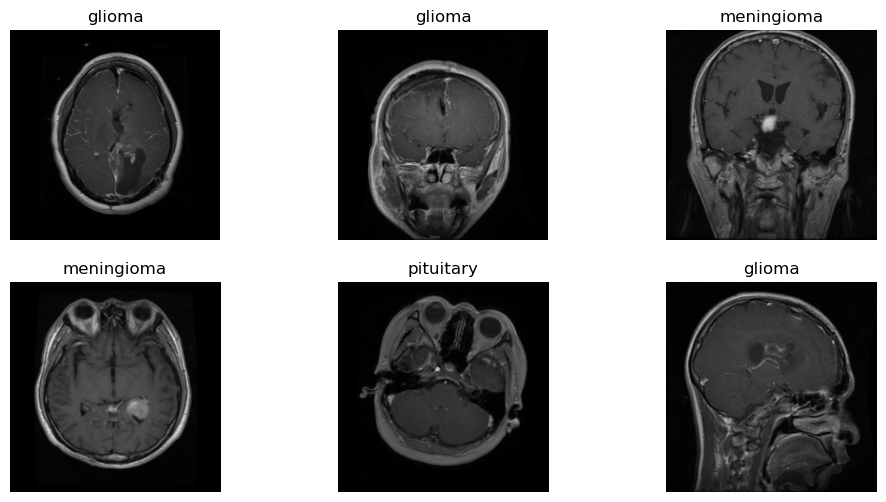

In [3]:
# Function to show a grid of images with labels
def show_images_with_labels(images, labels, classes, num_images=6):
    images = images / 2 + 0.5  # Unnormalize
    np_images = images.numpy()
    
    # Set up the grid dimensions: 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(np.transpose(np_images[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')

    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images with labels in a 2x3 grid
show_images_with_labels(images, labels, train_dataset.classes, num_images=6)

# Device Configuration for Model Training

We now set up the computing device for model training and evaluation. The code will first check if Apple's Metal Performance Shaders (MPS) backend, optimized for Apple Silicon, is available. If MPS is supported, the model and data are processed on the GPU to leverage its parallel processing power, improving computational efficiency. If MPS is not available, the CPU will be used. This setup ensures that the training process makes the best use of the available hardware for maximum performance.

In [4]:
# Device configuration for Apple Silicon (M3)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


# Model Architecture: Vision Transformer (ViT)

The core of this capstone project is the Vision Transformer (ViT) model, which is a novel architecture originally designed for natural language processing tasks but adapted for image classification. Unlike Convolutional Neural Networks (CNNs), ViTs do not rely on convolutions to process images. Instead, they divide an image into patches and treat each patch as a token, similar to words in a text sequence. The self-attention mechanism of transformers allows the model to capture global context, making it particularly effective for complex tasks like medical image classification.

In this implementation, we utilized PyTorch, a deep learning framework, to construct and train the ViT model. The model is designed with a series of transformer blocks, each consisting of multi-head self-attention layers and feed-forward networks. This structure enables the model to process the spatial relationships between patches and generate a comprehensive representation of the image.

In [10]:
from vit_pytorch import ViT
from torch import nn, optim

# Define the Vision Transformer model
model = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 4,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # L2 regularization

model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=512, bias=True)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0

# Training and Evaluation

This ViT model will be trained over 20 epochs, with the training process involving forward propagation, backpropagation, and optimization using the Adam optimizer. Cross-Entropy Loss will be employed as the objective function, given its suitability for multi-class classification. Throughout training, the model’s performance will be continuously monitored on the validation set via accuracy metrics.

In [6]:
# Training loop
epochs = 20
loss_values = []  # List to store loss values

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)  # Store the loss for each epoch
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# Save the trained model
torch.save(model.state_dict(), 'vit_mri_model.pth')

Epoch 1/20, Loss: 0.7634594617775698
Epoch 2/20, Loss: 0.4179124687304044
Epoch 3/20, Loss: 0.28578538818066346
Epoch 4/20, Loss: 0.20698991859092392
Epoch 5/20, Loss: 0.18036695325216434
Epoch 6/20, Loss: 0.14367586488747064
Epoch 7/20, Loss: 0.11101327283963477
Epoch 8/20, Loss: 0.09322663585983175
Epoch 9/20, Loss: 0.07541373096583359
Epoch 10/20, Loss: 0.07378543761569237
Epoch 11/20, Loss: 0.05810084416304699
Epoch 12/20, Loss: 0.05425449656764847
Epoch 13/20, Loss: 0.0572432308996294
Epoch 14/20, Loss: 0.04596431559542267
Epoch 15/20, Loss: 0.0336713509480651
Epoch 16/20, Loss: 0.04696792220194725
Epoch 17/20, Loss: 0.037356714707800553
Epoch 18/20, Loss: 0.03213389075130963
Epoch 19/20, Loss: 0.03583096243849534
Epoch 20/20, Loss: 0.02956639656337894


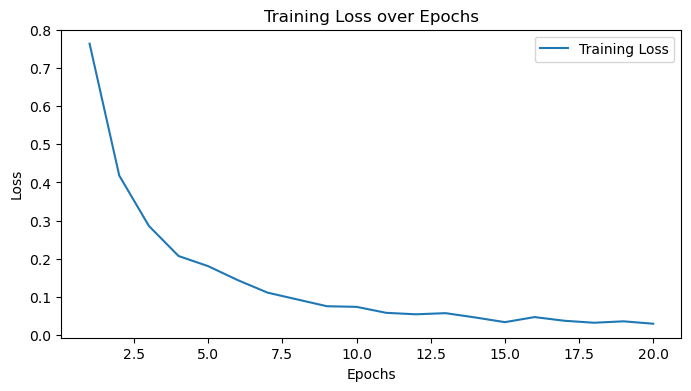

In [7]:
# Plotting the loss after training
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy of the model on the test images: 93.44012204424104%


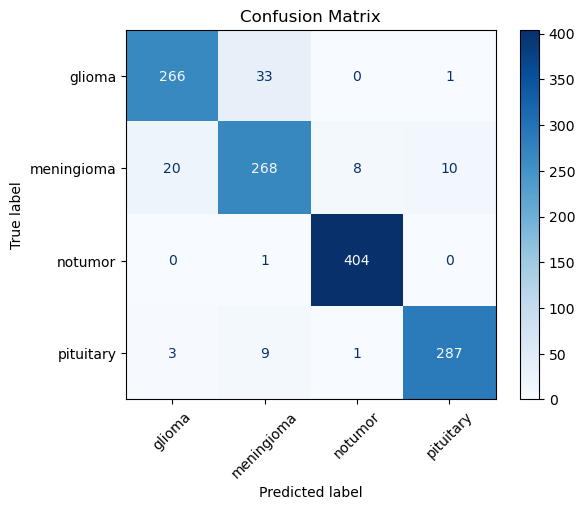

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the class names based on your train_dataset
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Evaluation on the test set
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store all labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

# Plotting confusion matrix with class labels
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Interpretation of the Model Results

## Accuracy
The model achieved an accuracy of **93.44%** on the test images. This high accuracy indicates that the model is effective at correctly classifying MRI images into the four categories: glioma, meningioma, pituitary tumor, and no tumor. It correctly predicted the class label for a significant majority of the test images.

## Confusion Matrix Analysis
The confusion matrix provides insights into the model's performance for each specific class:

- **Glioma**:
  - **True Positives (TP)**: 266 images were correctly classified as glioma.
  - **False Negatives (FN)**: 34 images were incorrectly classified as other classes (33 as meningioma and 1 as pituitary tumor).
- **Meningioma**:
  - **True Positives (TP)**: 268 images were correctly classified as meningioma.
  - **False Negatives (FN)**: 38 images were misclassified, with 20 as glioma, 8 as no tumor, and 10 as pituitary tumor.
- **No Tumor**:
  - **True Positives (TP)**: 404 images were correctly identified as having no tumor.
  - **False Negatives (FN)**: 1 image was misclassified as meningioma.
- **Pituitary Tumor**:
  - **True Positives (TP)**: 287 images were correctly classified as pituitary tumor.
  - **False Negatives (FN)**: 13 images were incorrectly classified as other tumor types (3 as glioma, 9 as meningioma, and 1 as no tumor).

# Conclusion
The core Vision Transformer model, trained and evaluated on a four-class brain MRI dataset, achieved 93.44 % test accuracy with high recall across glioma, meningioma, no tumor, and pituitary tumor categories. These results underscore the model’s ability to capture both local and global scan features, reducing inter-observer variability compared to manual review.

# References

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., & Houlsby, N. (2021). An image is worth 16×16 words: Transformers for image recognition at scale. In *International Conference on Learning Representations (ICLR)*.

Nickparvar, M. (2021, September 24). Brain Tumor MRI dataset. *Kaggle*. Retrieved from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

OpenAI. (2024). *ChatGPT* [Large language model]. Retrieved from https://chat.openai.com

Pedro, C. L., Richert, W., & Brucher, M. (2018). *Building machine learning systems with Python: Explore machine learning and deep learning techniques for building intelligent systems using scikit-learn and TensorFlow* (3rd ed.). Packt Publishing.

PyTorch. (n.d.). *Transformer* (PyTorch 2.4 documentation). Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer

Raghu, M., Unterthiner, T., Kornblith, S., Zhang, C., & Dosovitskiy, A. (2021). Do vision transformers see like convolutional neural networks? *Advances in Neural Information Processing Systems, 34*.

Shanmugamani, R. (2018). *Deep learning for computer vision: Expert techniques to train advanced neural networks using TensorFlow and Keras*. Packt Publishing.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. In *Advances in Neural Information Processing Systems, 30*.

Zaccone, G., & Karim, R. (2018). *Deep learning with TensorFlow: Explore neural networks and build intelligent systems with Python*. Packt Publishing.
